# Splitting the campaigns

Training the models on a part of every campaign and test the results on the remaining parts of the campaigns

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from LSTM import long_short_term_memory as LSTM
from rf import rf

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None, test_split=3/4):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']
    
    train_list = []
    test_list = []

    for _, group in df.groupby('campaign'):
        train_size = int(len(group) * test_split)

        train_data = group.iloc[:train_size]
        test_data = group.iloc[train_size:]
        
        train_list.append(train_data)
        test_list.append(test_data)

    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    
    X_train, mode_train = train_df[features], train_df[['Mode', 'campaign']]
    X_test, mode_test = test_df[features], test_df[['Mode', 'campaign']]

    return X_train, mode_train, X_test, mode_test


'''
    Returns a sequence indicating if a handover has happened when predicting 1 timestep ahead
'''
def check_handover(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y.iloc[i] == y.iloc[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y.iloc[i] == 0 and y.iloc[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y.iloc[i] == 1 and y.iloc[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

def check_handover_array(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y[i] == y[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y[i] == 0 and y[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y[i] == 1 and y[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

In [4]:
# Parameters
tf.random.set_seed(4567)
test_split = 2 / 3

# LSTM
n_steps_in = 5
n_steps_out = 1

n_first_units = 5
n_second_units = 10

# Random Forest
n_estimators = 100
max_depth = 10

In [5]:
# OP1
op1_X_train, op1_mode_train, op1_X_test, op1_mode_test = read_dataset('datasets/Op1_merged.csv', test_split=test_split)
op1_campaigns = op1_mode_train['campaign'].unique().tolist()
op1_test_campaigns = op1_mode_test['campaign'].unique().tolist()

# OP2
op2_X_train, op2_mode_train, op2_X_test, op2_mode_test = read_dataset('datasets/Op2_merged.csv', test_split=test_split)
op2_campaigns = op2_mode_train['campaign'].unique().tolist()
op2_test_campaigns = op2_mode_test['campaign'].unique().tolist()

In [6]:
op1_results = {}
op2_results = {}
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

In [7]:
# OP1
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            print(used_features)
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            op1_results[used_features] = LSTM(train=op1_X_train[features], test=op1_X_test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=op1_campaigns, test_campaigns=op1_test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

RSRP -> RSRP
RSRP, SINR -> RSRP
RSRP, RSRQ -> RSRP
RSRP, SINR, RSRQ -> RSRP
RSRP, SSS_RSRP -> RSRP
All -> RSRP
SINR -> SINR
RSRP, SINR -> SINR
SINR, RSRQ -> SINR
RSRP, SINR, RSRQ -> SINR
SINR, SSS_SINR -> SINR
All -> SINR
RSRQ -> RSRQ
RSRP, RSRQ -> RSRQ
SINR, RSRQ -> RSRQ
RSRP, SINR, RSRQ -> RSRQ
RSRQ, SSS_RSRQ -> RSRQ
All -> RSRQ
SSS_RSRP -> SSS_RSRP
SSS_RSRP, SSS_SINR -> SSS_RSRP
SSS_RSRP, SSS_RSRQ -> SSS_RSRP
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP
RSRP, SSS_RSRP -> SSS_RSRP
All -> SSS_RSRP
SSS_SINR -> SSS_SINR
SSS_RSRP, SSS_SINR -> SSS_SINR
SSS_SINR, SSS_RSRQ -> SSS_SINR
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR
SINR, SSS_SINR -> SSS_SINR
All -> SSS_SINR
SSS_RSRQ -> SSS_RSRQ
SSS_RSRP, SSS_RSRQ -> SSS_RSRQ
SSS_SINR, SSS_RSRQ -> SSS_RSRQ
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ
RSRQ, SSS_RSRQ -> SSS_RSRQ
All -> SSS_RSRQ


In [8]:
# OP2
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            print(used_features)
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            op2_results[used_features] = LSTM(train=op2_X_train[features], test=op2_X_test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=op2_campaigns, test_campaigns=op2_test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

RSRP -> RSRP
RSRP, SINR -> RSRP
RSRP, RSRQ -> RSRP
RSRP, SINR, RSRQ -> RSRP
RSRP, SSS_RSRP -> RSRP
All -> RSRP
SINR -> SINR
RSRP, SINR -> SINR
SINR, RSRQ -> SINR
RSRP, SINR, RSRQ -> SINR
SINR, SSS_SINR -> SINR
All -> SINR
RSRQ -> RSRQ
RSRP, RSRQ -> RSRQ
SINR, RSRQ -> RSRQ
RSRP, SINR, RSRQ -> RSRQ
RSRQ, SSS_RSRQ -> RSRQ
All -> RSRQ
SSS_RSRP -> SSS_RSRP
SSS_RSRP, SSS_SINR -> SSS_RSRP
SSS_RSRP, SSS_RSRQ -> SSS_RSRP
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP
RSRP, SSS_RSRP -> SSS_RSRP
All -> SSS_RSRP
SSS_SINR -> SSS_SINR
SSS_RSRP, SSS_SINR -> SSS_SINR
SSS_SINR, SSS_RSRQ -> SSS_SINR
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR
SINR, SSS_SINR -> SSS_SINR
All -> SSS_SINR
SSS_RSRQ -> SSS_RSRQ
SSS_RSRP, SSS_RSRQ -> SSS_RSRQ
SSS_SINR, SSS_RSRQ -> SSS_RSRQ
SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ
RSRQ, SSS_RSRQ -> SSS_RSRQ
All -> SSS_RSRQ


In [9]:
op1_df_results = pd.DataFrame.from_dict(op1_results, orient='index')

op1_df_results.reset_index(inplace=True)
op1_df_results.rename(columns={'index': 'Combination'}, inplace=True)
op1_df_results = op1_df_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
op1_df_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00031,0.00023,0.42,0.45
1,"RSRP, SINR -> RSRP",0.00031,0.00022,0.44,0.43
2,"RSRP, RSRQ -> RSRP",0.00031,0.00021,0.23,0.20
3,"RSRP, SINR, RSRQ -> RSRP",0.00032,0.00021,0.31,0.24
4,"RSRP, SSS_RSRP -> RSRP",0.00031,0.00022,0.34,0.39
5,All -> RSRP,0.00031,0.00021,0.21,0.21
6,SINR -> SINR,0.00074,0.00046,0.38,0.33
7,"RSRP, SINR -> SINR",0.00074,0.00046,0.35,0.31
8,"SINR, RSRQ -> SINR",0.00074,0.00045,0.29,0.27
9,"RSRP, SINR, RSRQ -> SINR",0.00074,0.00045,0.27,0.26


In [10]:
op2_df_results = pd.DataFrame.from_dict(op2_results, orient='index')

op2_df_results.reset_index(inplace=True)
op2_df_results.rename(columns={'index': 'Combination'}, inplace=True)
op2_df_results = op2_df_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
op2_df_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00024,0.00031,0.26,0.45
1,"RSRP, SINR -> RSRP",0.00024,0.00030,0.24,0.44
2,"RSRP, RSRQ -> RSRP",0.00024,0.00029,0.24,0.44
3,"RSRP, SINR, RSRQ -> RSRP",0.00024,0.00032,0.32,0.46
4,"RSRP, SSS_RSRP -> RSRP",0.00024,0.00031,0.23,0.39
5,All -> RSRP,0.00024,0.00034,0.40,0.50
6,SINR -> SINR,0.00044,0.00042,0.25,0.41
7,"RSRP, SINR -> SINR",0.00044,0.00042,0.23,0.37
8,"SINR, RSRQ -> SINR",0.00044,0.00042,0.25,0.41
9,"RSRP, SINR, RSRQ -> SINR",0.00044,0.00042,0.25,0.40


## Plots for signal strength indicators

### OP1

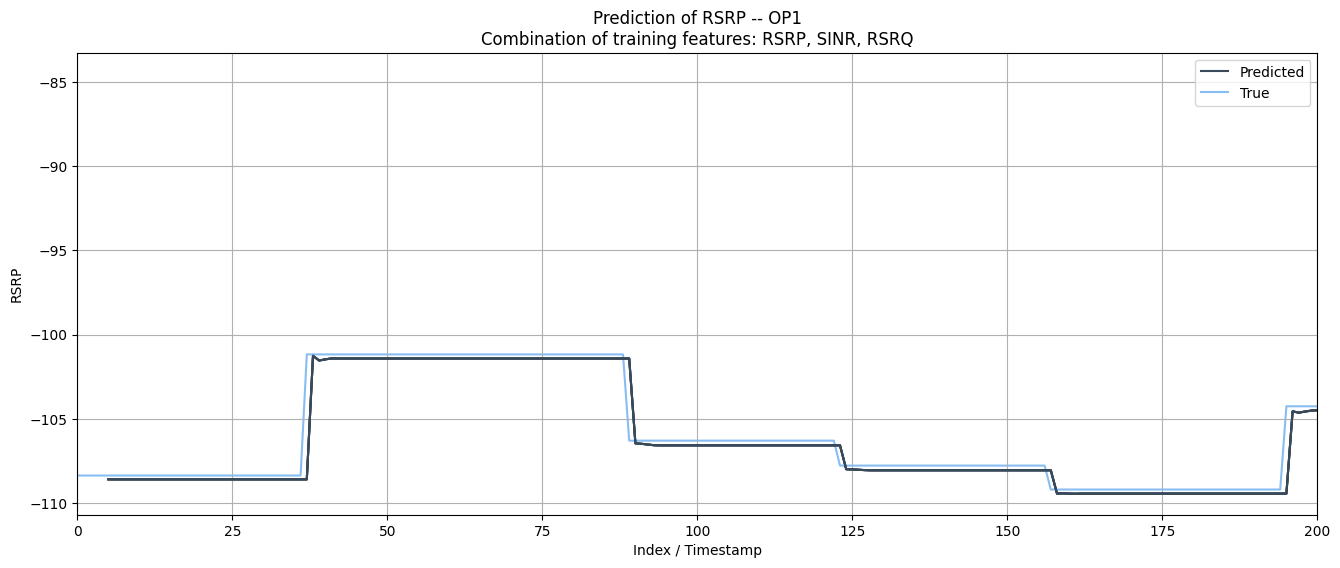

In [11]:
selected_rsrp_comb = 'RSRP, SINR, RSRQ -> RSRP'
op1_rsrp_comb = op1_results[selected_rsrp_comb]
op1_rsrp_pred = op1_rsrp_comb['y_pred']
op1_rsrp_true = op1_rsrp_comb['y_true']
op1_rsrp_train_pred = op1_rsrp_comb['train_pred']
op1_rsrp_train_true = op1_rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(op1_rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(op1_rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of RSRP -- OP1\nCombination of training features: RSRP, SINR, RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

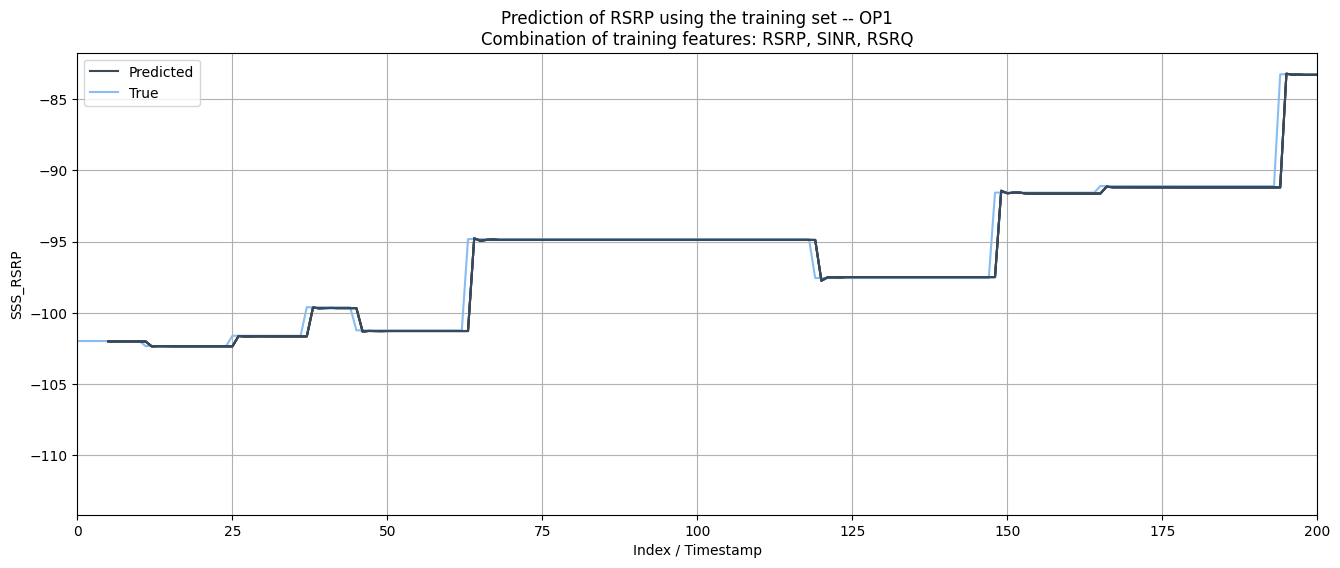

In [12]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(op1_rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(op1_rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of RSRP using the training set -- OP1\nCombination of training features: RSRP, SINR, RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

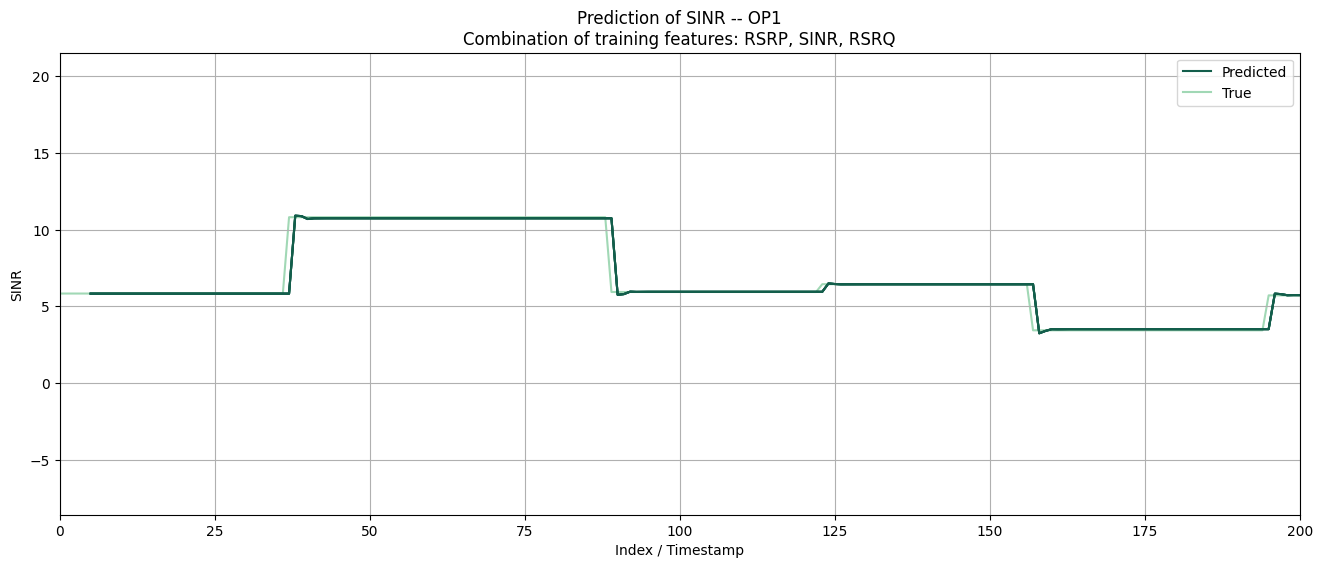

In [13]:
selected_sinr_comb = 'RSRP, SINR, RSRQ -> SINR'
op1_sinr_comb = op1_results[selected_sinr_comb]
op1_sinr_pred = op1_sinr_comb['y_pred']
op1_sinr_true = op1_sinr_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(op1_sinr_pred, label='Predicted', color=sinr_colors[0], zorder=2)
true = plt.plot(op1_sinr_true, label='True', color=sinr_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SINR')
plt.title(f'Prediction of SINR -- OP1\nCombination of training features: RSRP, SINR, RSRQ')
plt.xlim((0, 200))
plt.legend(handles=[pred[0], true[0]])
plt.show()

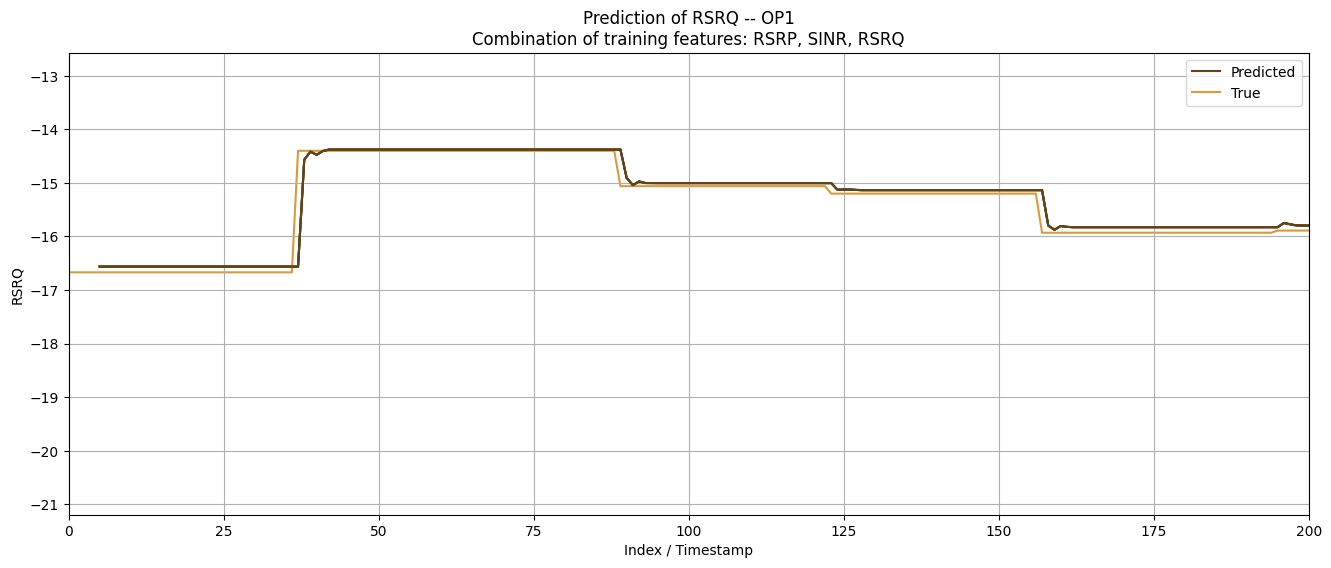

In [14]:
selected_rsrq_comb = 'RSRP, SINR, RSRQ -> RSRQ'
op1_rsrq_comb = op1_results[selected_rsrq_comb]
op1_rsrq_pred = op1_rsrq_comb['y_pred']
op1_rsrq_true = op1_rsrq_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(op1_rsrq_pred, label='Predicted', color=rsrq_colors[0], zorder=2)
true = plt.plot(op1_rsrq_true, label='True', color=rsrq_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRQ')
plt.xlim((0, 200))
plt.title(f'Prediction of RSRQ -- OP1\nCombination of training features: RSRP, SINR, RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

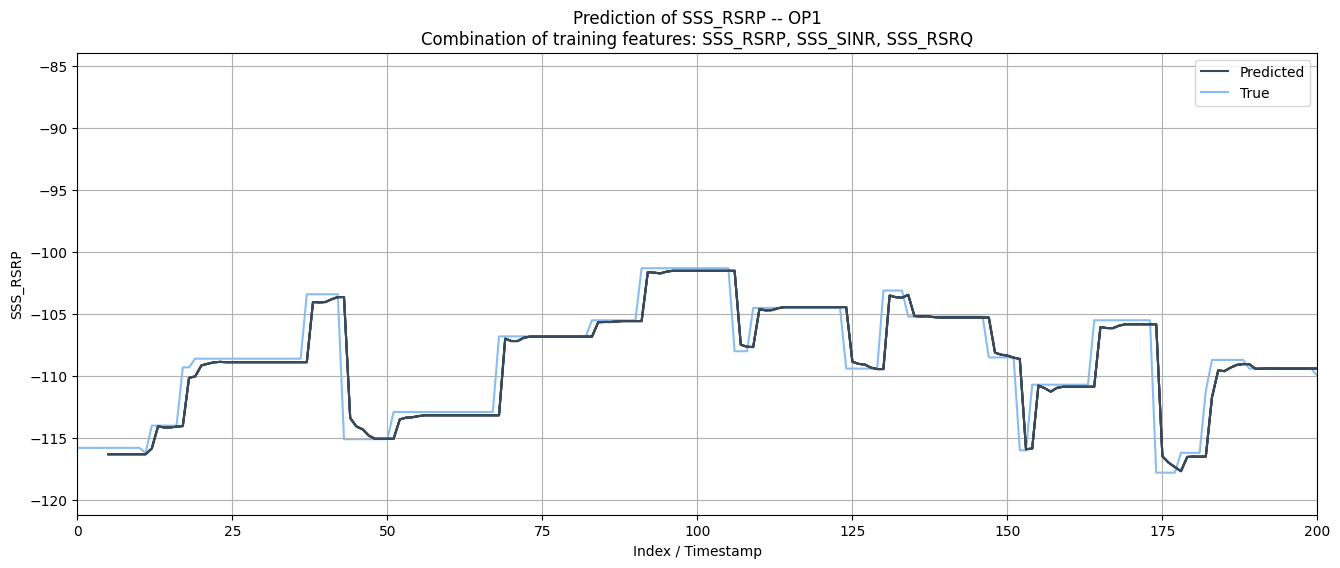

In [15]:
selected_sss_rsrp_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP'
op1_sss_rsrp_comb = op1_results[selected_sss_rsrp_comb]
op1_sss_rsrp_pred = op1_sss_rsrp_comb['y_pred']
op1_sss_rsrp_true = op1_sss_rsrp_comb['y_true']
op1_sss_rsrp_train_pred = op1_sss_rsrp_comb['train_pred']
op1_sss_rsrp_train_true = op1_sss_rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(op1_sss_rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(op1_sss_rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_RSRP -- OP1\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

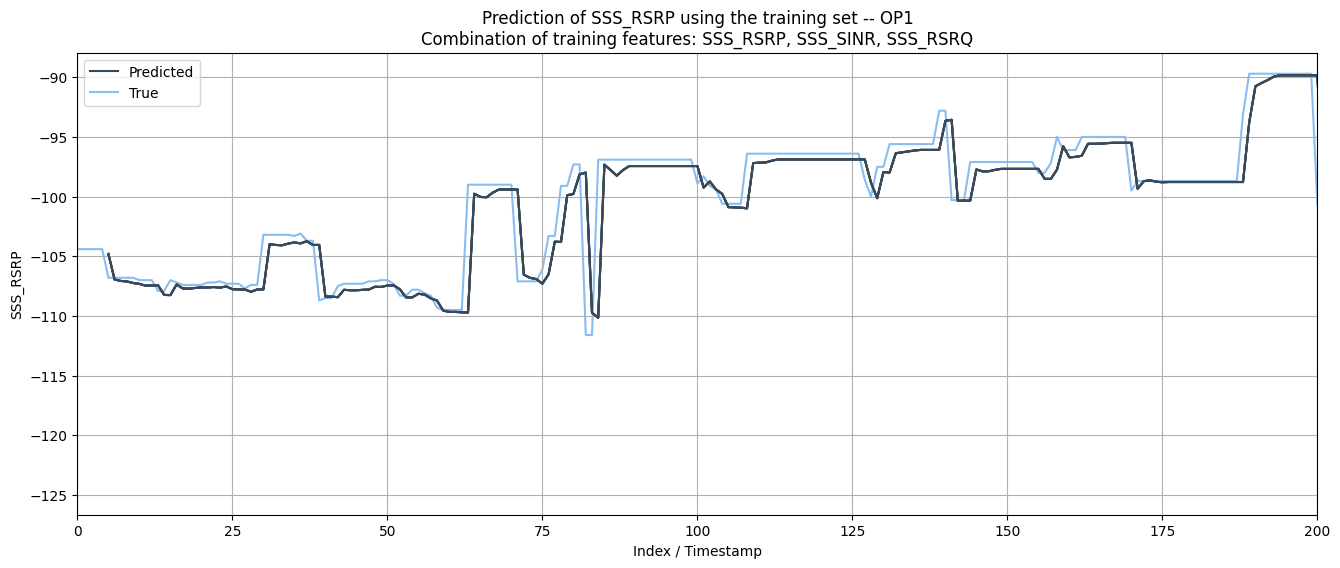

In [16]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(op1_sss_rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(op1_sss_rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of SSS_RSRP using the training set -- OP1\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

### OP2

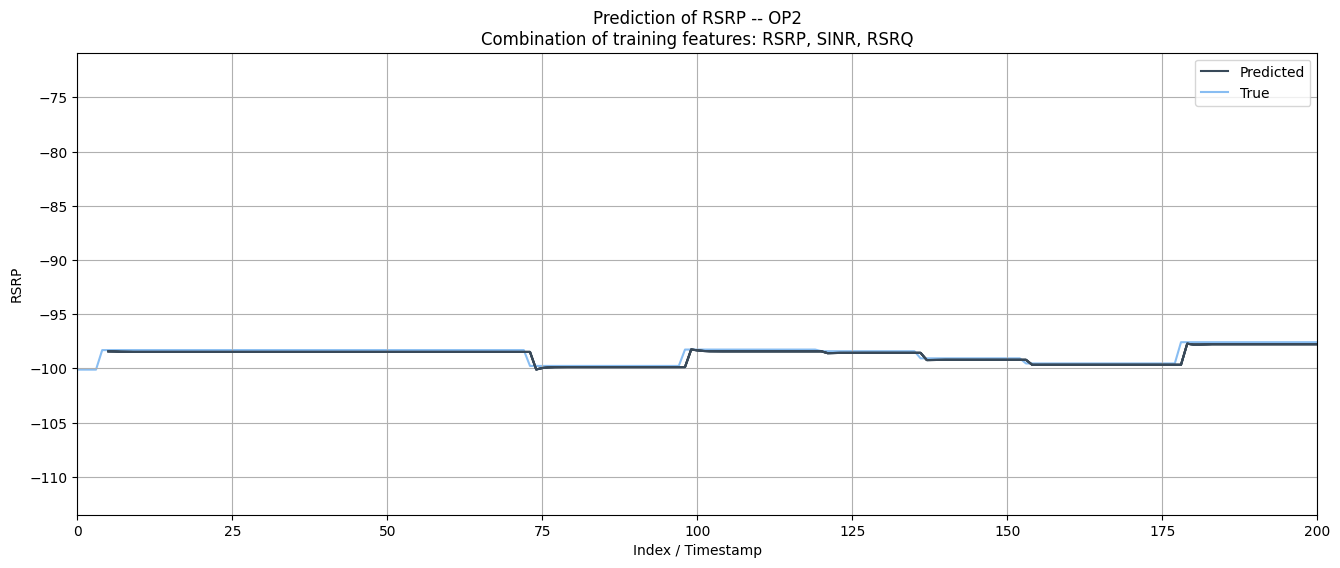

In [17]:
op2_rsrp_comb = op2_results[selected_rsrp_comb]
op2_rsrp_pred = op2_rsrp_comb['y_pred']
op2_rsrp_true = op2_rsrp_comb['y_true']
op2_rsrp_train_pred = op2_rsrp_comb['train_pred']
op2_rsrp_train_true = op2_rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(op2_rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(op2_rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of RSRP -- OP2\nCombination of training features: RSRP, SINR, RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

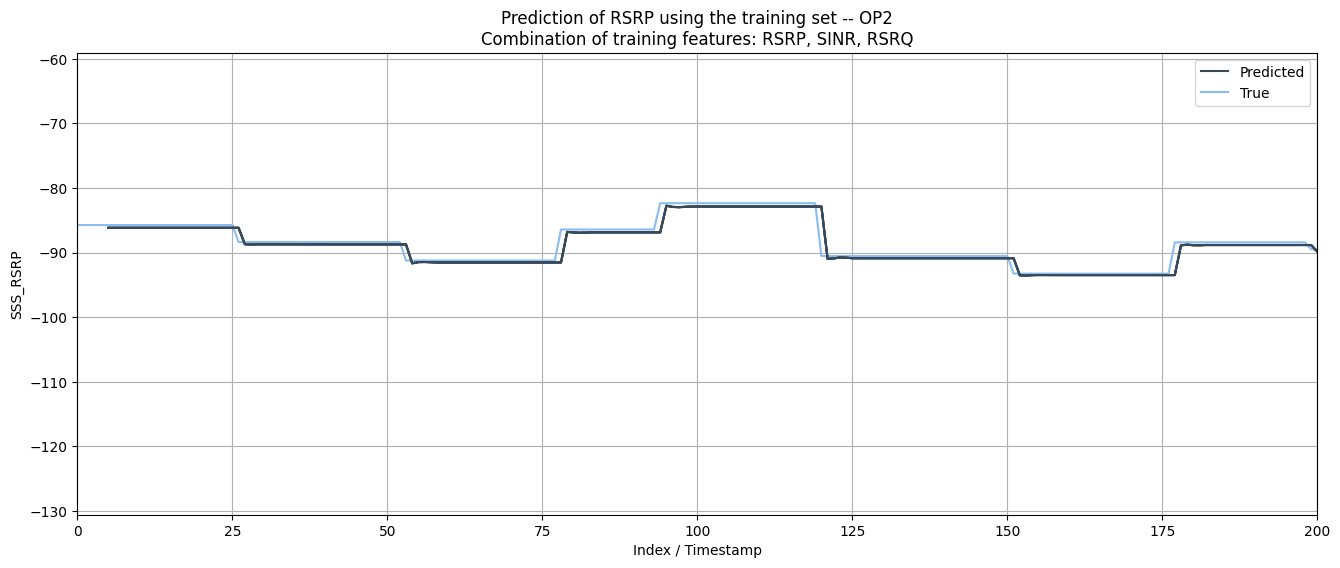

In [18]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(op2_rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(op2_rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of RSRP using the training set -- OP2\nCombination of training features: RSRP, SINR, RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

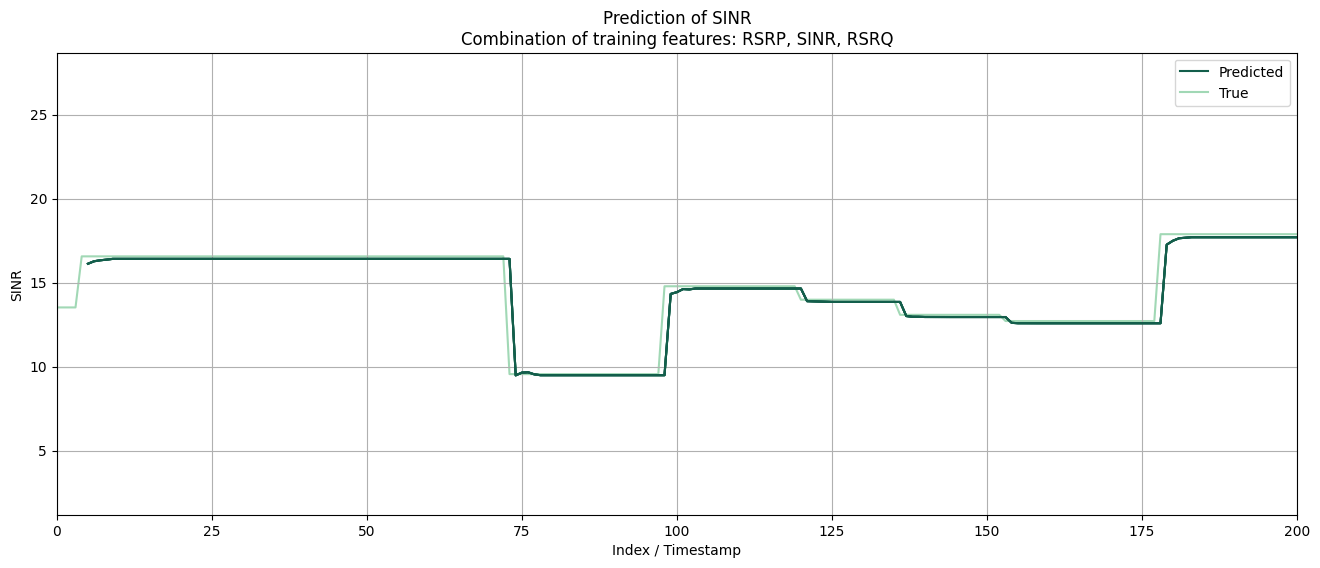

In [19]:
op2_sinr_comb = op2_results[selected_sinr_comb]
op2_sinr_pred = op2_sinr_comb['y_pred']
op2_sinr_true = op2_sinr_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(op2_sinr_pred, label='Predicted', color=sinr_colors[0], zorder=2)
true = plt.plot(op2_sinr_true, label='True', color=sinr_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SINR')
plt.title(f'Prediction of SINR\nCombination of training features: RSRP, SINR, RSRQ')
plt.xlim((0, 200))
plt.legend(handles=[pred[0], true[0]])
plt.show()

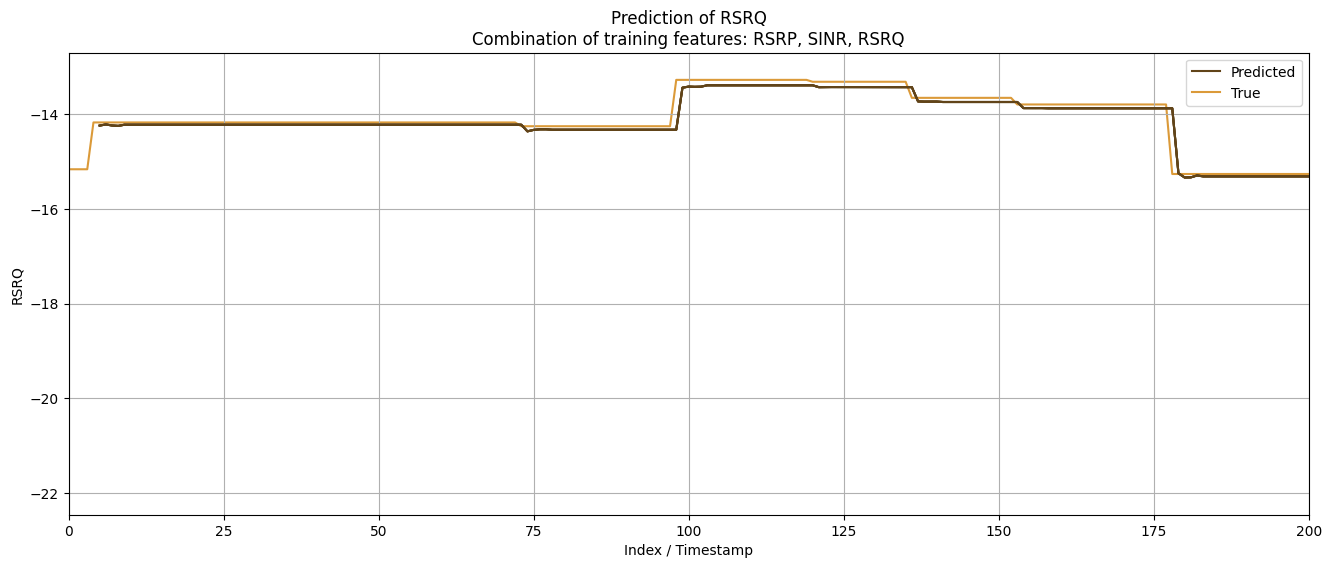

In [20]:
op2_rsrq_comb = op2_results[selected_rsrq_comb]
op2_rsrq_pred = op2_rsrq_comb['y_pred']
op2_rsrq_true = op2_rsrq_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(op2_rsrq_pred, label='Predicted', color=rsrq_colors[0], zorder=2)
true = plt.plot(op2_rsrq_true, label='True', color=rsrq_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRQ')
plt.xlim((0, 200))
plt.title(f'Prediction of RSRQ\nCombination of training features: RSRP, SINR, RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

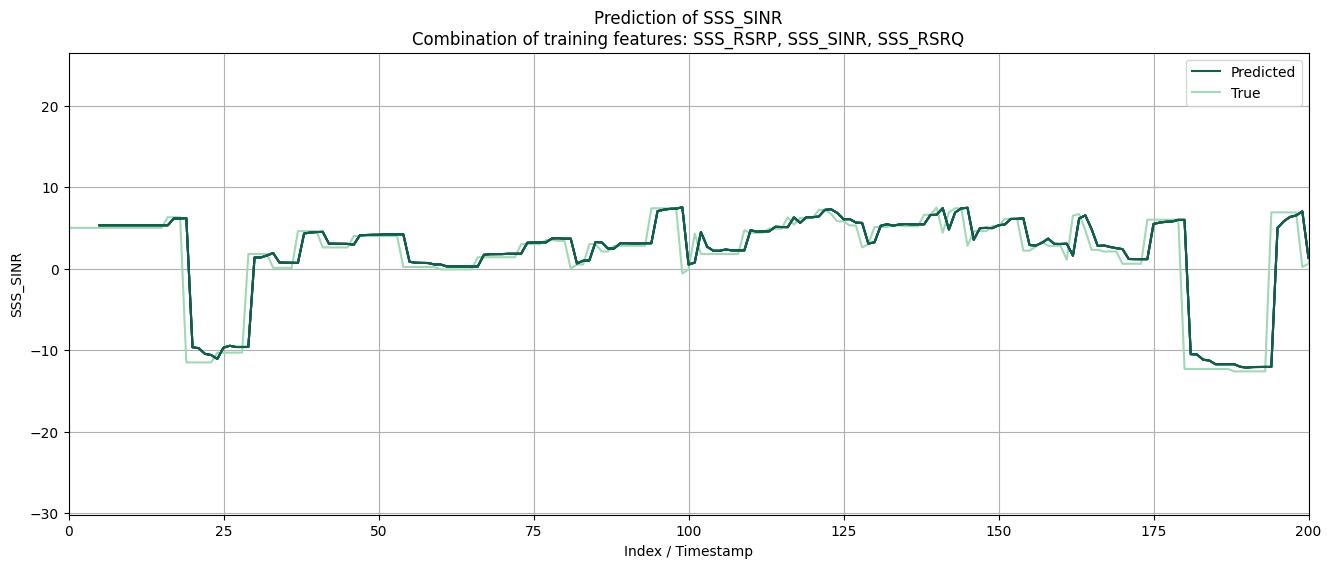

In [21]:
selected_sss_sinr_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR'
op2_sss_sinr_comb = op2_results[selected_sss_sinr_comb]
op2_sss_sinr_pred = op2_sss_sinr_comb['y_pred']
op2_sss_sinr_true = op2_sss_sinr_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(op2_sss_sinr_pred, label='Predicted', color=sinr_colors[0], zorder=3)
true = plt.plot(op2_sss_sinr_true, label='True', color=sinr_colors[2], zorder=2)
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_SINR')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_SINR\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

## Classification of mode using Random Forest

In [22]:
est_try = [5, 10, 20, 50, 80, 100, 120, 150, 200, 250, 300]
min_leaf_size = [1, 2, 5, 7, 9, 12, 15]

op1_rf_results = {}

feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        op1_rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=op1_X_train[feats], X_test=op1_X_test[feats], mode_train=op1_mode_train, mode_test=op1_mode_test, n_estimators=est, min_samples_leaf=leaf, campaigns=op1_campaigns, test_campaigns=op1_test_campaigns, features=features)

op1_rf_results_df = pd.DataFrame.from_dict(op1_rf_results, orient='index')
op1_rf_results_df.reset_index(inplace=True)
op1_rf_results_df.rename(columns={'index': 'Parameters'}, inplace=True)
op1_rf_results_df = op1_rf_results_df.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
op1_rf_results_df

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.673,0.354,0.551,0.996,0.993,0.996
1,"n_est: 5, min_leaf: 2",0.662,0.335,0.511,0.994,0.990,0.994
2,"n_est: 5, min_leaf: 5",0.671,0.350,0.542,0.988,0.980,0.988
3,"n_est: 5, min_leaf: 7",0.664,0.346,0.553,0.982,0.971,0.983
4,"n_est: 5, min_leaf: 9",0.673,0.352,0.542,0.980,0.967,0.982
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.710,0.391,0.518,0.993,0.987,0.995
73,"n_est: 300, min_leaf: 7",0.711,0.395,0.531,0.991,0.985,0.992
74,"n_est: 300, min_leaf: 9",0.708,0.389,0.523,0.989,0.982,0.990
75,"n_est: 300, min_leaf: 12",0.707,0.387,0.519,0.986,0.976,0.987


In [23]:
# OP1

est_try = [5, 10, 20, 50, 80, 100, 120, 150, 200, 250, 300]
depth_try = [5, 7, 10, 12, 15, 18, 20]

op1_rf_results = {}

feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for depth in depth_try:
        op1_rf_results[f'n_est: {est}, depth: {depth}'] = rf(X_train=op1_X_train[feats], X_test=op1_X_test[feats], mode_train=op1_mode_train, mode_test=op1_mode_test, n_estimators=est, max_depth=depth, campaigns=op1_campaigns, test_campaigns=op1_test_campaigns, features=features)

op1_rf_results_df = pd.DataFrame.from_dict(op1_rf_results, orient='index')
op1_rf_results_df.reset_index(inplace=True)
op1_rf_results_df.rename(columns={'index': 'Parameters'}, inplace=True)
op1_rf_results_df = op1_rf_results_df.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
op1_rf_results_df

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, depth: 5",0.546,0.296,0.741,0.652,0.530,0.818
1,"n_est: 5, depth: 7",0.622,0.342,0.735,0.718,0.600,0.787
2,"n_est: 5, depth: 10",0.628,0.325,0.610,0.847,0.769,0.858
3,"n_est: 5, depth: 12",0.674,0.363,0.597,0.904,0.847,0.915
4,"n_est: 5, depth: 15",0.674,0.358,0.565,0.955,0.938,0.946
...,...,...,...,...,...,...,...
72,"n_est: 300, depth: 10",0.679,0.375,0.637,0.873,0.808,0.878
73,"n_est: 300, depth: 12",0.701,0.393,0.608,0.927,0.888,0.926
74,"n_est: 300, depth: 15",0.711,0.400,0.569,0.977,0.968,0.973
75,"n_est: 300, depth: 18",0.705,0.388,0.540,0.994,0.992,0.993


In [24]:
# OP2
op2_rf_results = {}

min_leaf_size = [1, 2, 5, 7, 9, 12, 15]

for est in est_try:
    for leaf in min_leaf_size:
        op2_rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=op2_X_train[feats], X_test=op2_X_test[feats], mode_train=op2_mode_train, mode_test=op2_mode_test, n_estimators=est, min_samples_leaf=leaf, campaigns=op2_campaigns, test_campaigns=op2_test_campaigns, features=features)

op2_rf_results_df = pd.DataFrame.from_dict(op2_rf_results, orient='index')
op2_rf_results_df.reset_index(inplace=True)
op2_rf_results_df.rename(columns={'index': 'Combination'}, inplace=True)
op2_rf_results_df = op2_rf_results_df.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
op2_rf_results_df

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.782,0.618,0.631,0.999,0.997,0.999
1,"n_est: 5, min_leaf: 2",0.772,0.604,0.600,0.997,0.995,0.996
2,"n_est: 5, min_leaf: 5",0.787,0.632,0.619,0.993,0.987,0.990
3,"n_est: 5, min_leaf: 7",0.777,0.609,0.628,0.991,0.982,0.988
4,"n_est: 5, min_leaf: 9",0.792,0.636,0.645,0.987,0.973,0.986
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.815,0.697,0.628,0.996,0.993,0.994
73,"n_est: 300, min_leaf: 7",0.813,0.692,0.625,0.995,0.990,0.992
74,"n_est: 300, min_leaf: 9",0.815,0.696,0.631,0.993,0.986,0.990
75,"n_est: 300, min_leaf: 12",0.817,0.695,0.647,0.991,0.982,0.987


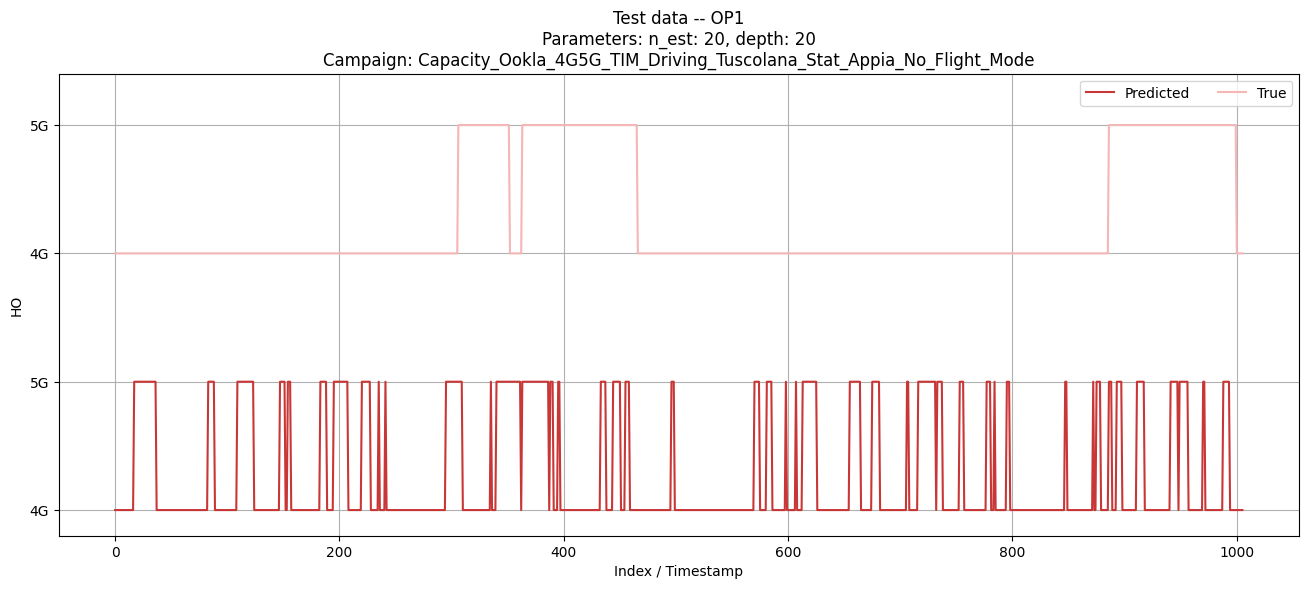

In [25]:
# OP1
selected_rf_comb = 'n_est: 20, depth: 20'
op1_rf_comb = op1_rf_results[selected_rf_comb]
op1_rf_pred_true = op1_rf_comb['y_pred']
op1_rf_true = op1_rf_comb['y_true']
op1_model = op1_rf_comb['model']
to_pred = op1_X_train[op1_X_train['campaign'] == op1_campaigns[0]]
op1_train_pred = op1_model.predict(to_pred[feature_selection[-1]])

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(op1_rf_pred_true, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(op1_rf_true['Mode'] + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- OP1\nParameters: {selected_rf_comb}\nCampaign: {op1_campaigns[0]}')
plt.legend(ncols=3, loc='best')
plt.show()

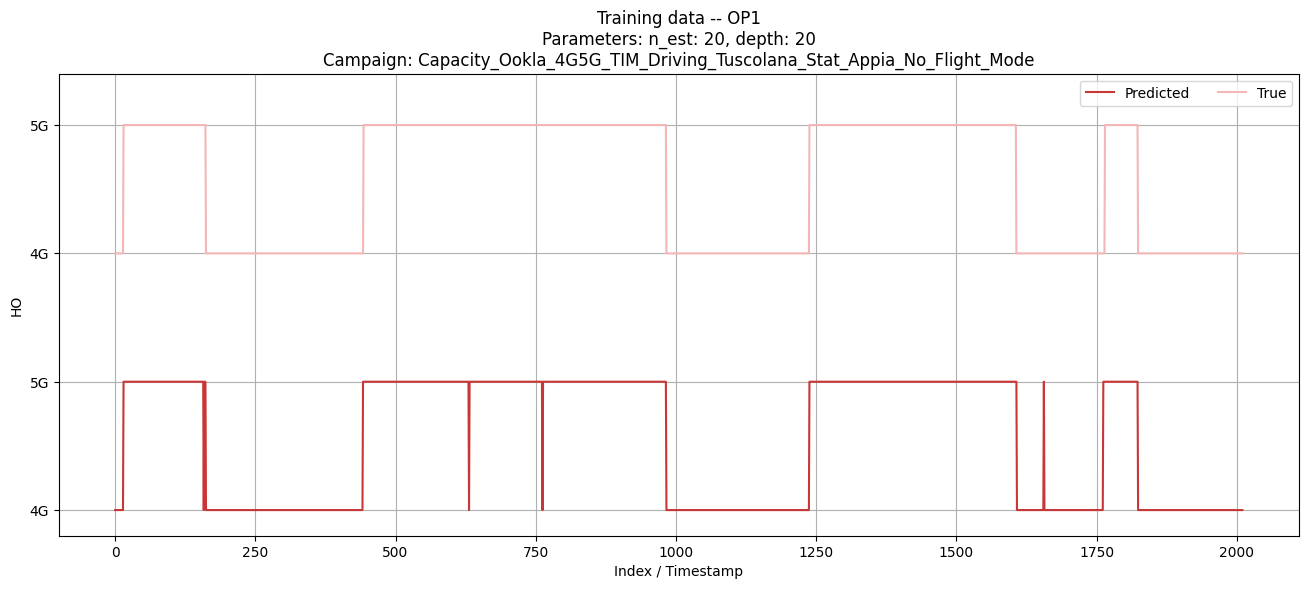

In [26]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(op1_train_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(op1_mode_train[op1_mode_train['campaign'] == op1_campaigns[0]]['Mode'] + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Training data -- OP1\nParameters: {selected_rf_comb}\nCampaign: {op1_campaigns[0]}')
plt.legend(ncols=3, loc='best')
plt.show()

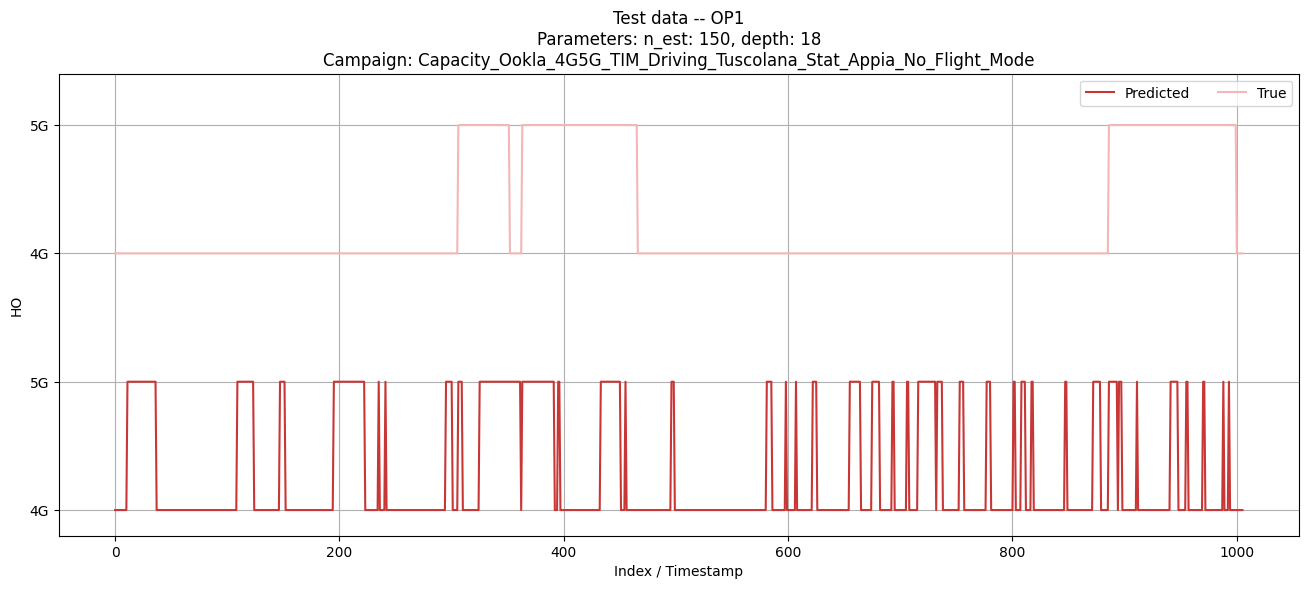

In [27]:
selected_rf_comb = 'n_est: 150, depth: 18'
op1_rf_comb = op1_rf_results[selected_rf_comb]
op1_rf_pred_true = op1_rf_comb['y_pred']
op1_rf_true = op1_rf_comb['y_true']
op1_model = op1_rf_comb['model']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(op1_rf_pred_true, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(op1_rf_true['Mode'] + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- OP1\nParameters: {selected_rf_comb}\nCampaign: {op1_campaigns[0]}')
plt.legend(ncols=3, loc='best')
plt.show()

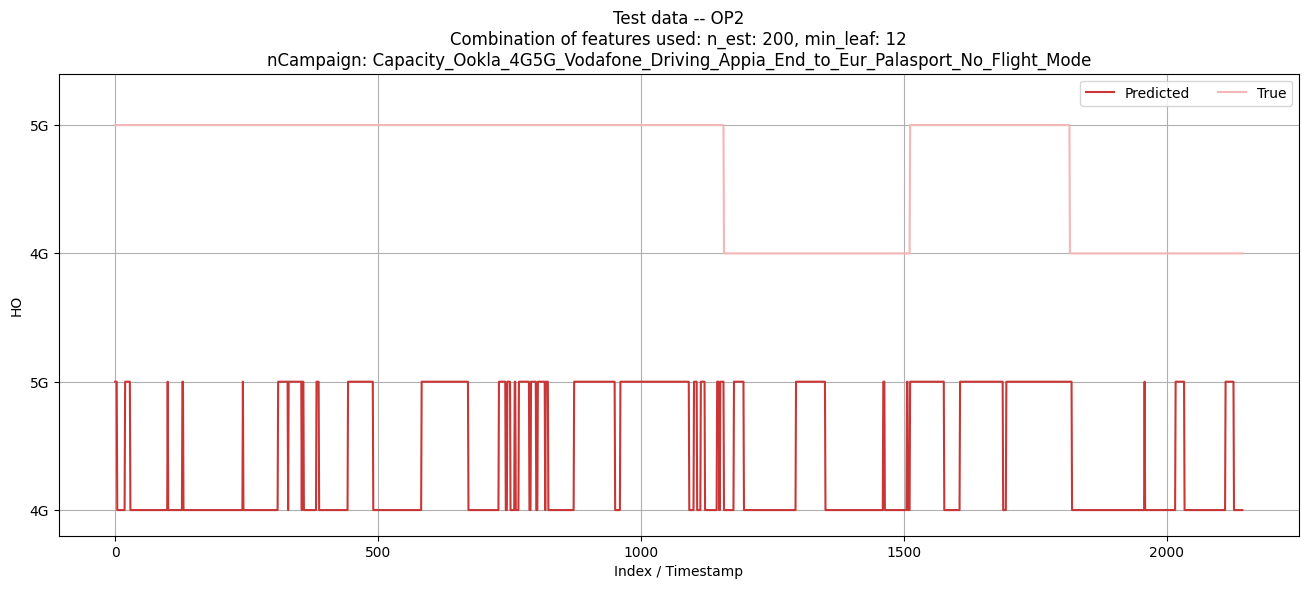

In [28]:
# OP2
selected_rf_comb = 'n_est: 200, min_leaf: 12'
op2_rf_comb = op2_rf_results[selected_rf_comb]
op2_rf_pred_true = op2_rf_comb['y_pred']
op2_rf_true = op2_rf_comb['y_true']
op2_model = op2_rf_comb['model']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(op2_rf_pred_true, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(op2_rf_true['Mode'] + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- OP2\nCombination of features used: {selected_rf_comb}\nnCampaign: {op2_campaigns[0]}')
plt.legend(ncols=3, loc='best')
plt.show()

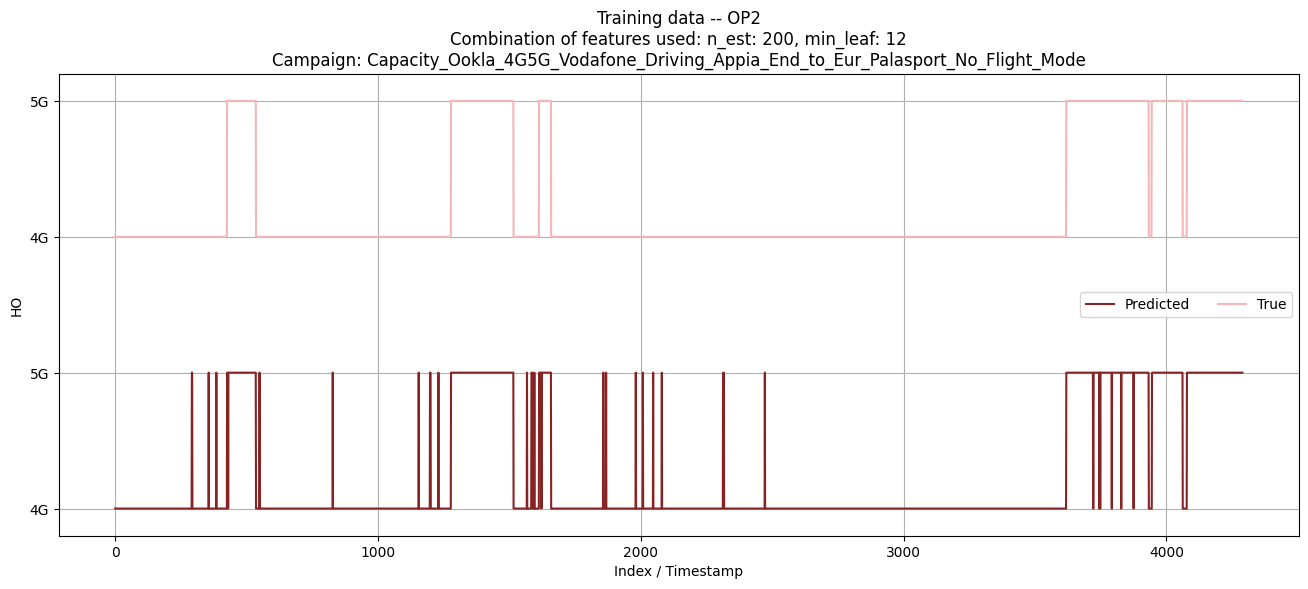

In [29]:
to_pred = op2_X_train[op2_X_train['campaign'] == op2_campaigns[0]]
to_plot = op2_mode_train[op2_mode_train['campaign'] == op2_campaigns[0]]

op2_rf_train_pred = op2_model.predict(to_pred[feature_selection[-1]])

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(op2_rf_train_pred, color=mode_colors[0], label='Predicted', zorder=4)
plt.plot(to_plot['Mode'] + 2, color=mode_colors[3], label='True', zorder=2)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.2))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Training data -- OP2\nCombination of features used: {selected_rf_comb}\nCampaign: {op2_campaigns[0]}')
plt.legend(ncols=3, loc='best')
plt.show()